In [2]:
import json
import os
import cv2
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from collections import defaultdict, Counter
from tabulate import tabulate

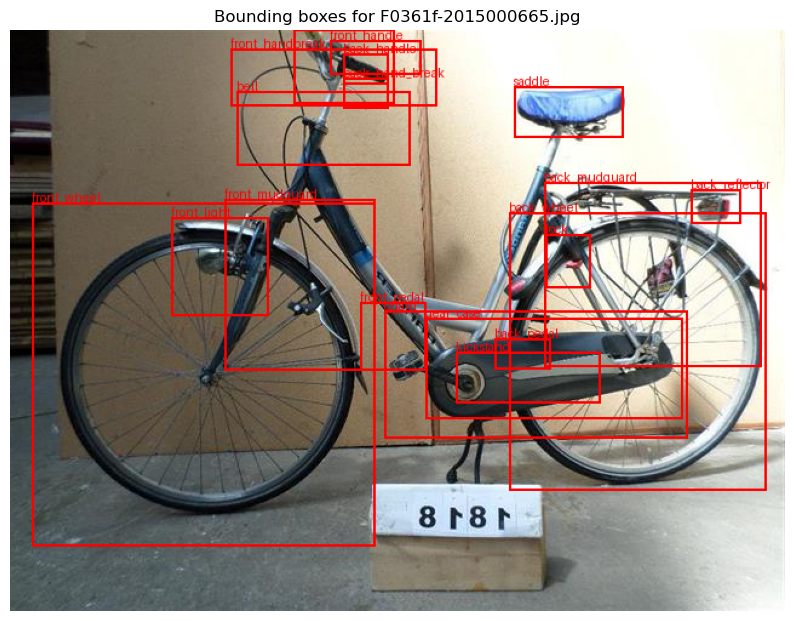

In [3]:
# Paths
annotations_path = "../../data/processed/final_annotations.json"
images_dir = "../../data/images"

# Load annotations
with open(annotations_path, "r") as f:
    annotations = json.load(f)

# Get all image filenames from the annotation
image_filenames = list(annotations["images"].keys())

# Select specific ranges
selected_filenames = (
    image_filenames[2000:2010]
    + image_filenames[5000:5010]
    + image_filenames[3950:3960]
    + image_filenames[7745:7755]
)

# Function to visualize bounding boxes on a given image filename
def visualize_image(filename):
    image_path = os.path.join(images_dir, filename)

    if not os.path.exists(image_path):
        print(f"Image not found: {filename}")
        return

    if filename not in annotations["images"]:
        print(f"No annotation found for: {filename}")
        return

    image = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(image)

    parts = annotations["images"][filename].get("available_parts", [])
    for part in parts:
        # if part["part_name"] == "steer":
            bbox = part["absolute_bounding_box"]
            part_name = part["part_name"]
            left = bbox["left"]
            top = bbox["top"]
            right = left + bbox["width"]
            bottom = top + bbox["height"]

            draw.rectangle([left, top, right, bottom], outline="red", width=2)
            draw.text((left, top - 10), part_name, fill="red")

    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.title(f"Bounding boxes for {filename}")
    plt.axis("off")
    plt.show()

# Visualize selected batches
# for filename in selected_filenames:
#     visualize_image(filename)

# Example usage for a single specific image:
visualize_image("F0361f-2015000665.jpg")


In [4]:
def find_image_extremes(image_dir, extensions={'.jpg', '.jpeg', '.png'}):
    max_width = 0
    max_height = 0
    min_width = float('inf')
    min_height = float('inf')
    max_image_path = ""
    min_image_path = ""

    # Walk through directory
    for root, _, files in os.walk(image_dir):
        for file in files:
            if os.path.splitext(file)[1].lower() in extensions:
                path = os.path.join(root, file)
                img = cv2.imread(path)
                if img is None:
                    print(f"Warning: Could not read image {path}")
                    continue
                h, w = img.shape[:2]

                # Update max
                if w * h > max_width * max_height:
                    max_width, max_height = w, h
                    max_image_path = path

                # Update min
                if w * h < min_width * min_height:
                    min_width, min_height = w, h
                    min_image_path = path

    print(f"Largest image: {max_image_path} ({max_width} x {max_height})")
    print(f"Smallest image: {min_image_path} ({min_width} x {min_height})")
    return (max_width, max_height, max_image_path), (min_width, min_height, min_image_path)

# Example usage
image_directory = "../../data/images"
find_image_extremes(image_directory)

Largest image: ../../data/images/G1783-2015001284.jpg (640 x 640)
Smallest image: ../../data/images/F0203f-2016000060.jpg (320 x 240)


((640, 640, '../../data/images/G1783-2015001284.jpg'),
 (320, 240, '../../data/images/F0203f-2016000060.jpg'))

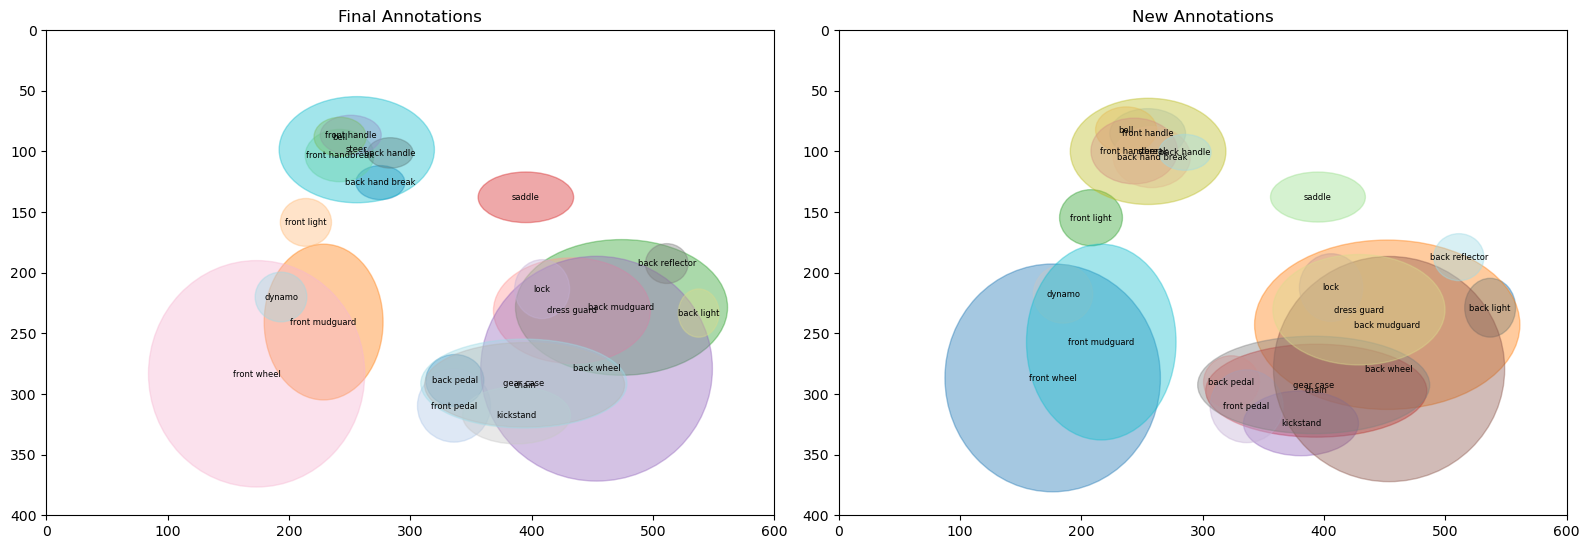

In [5]:
def load_avg_positions(annotations_path):
    with open(annotations_path, 'r') as f:
        annotations = json.load(f)

    all_parts = annotations['all_parts']
    images = annotations['images']

    part_positions = {part: [] for part in all_parts}
    part_sizes = {part: [] for part in all_parts}

    for img_data in images.values():
        for part in img_data['available_parts']:
            name = part['part_name']
            bbox = part['absolute_bounding_box']
            center_x = bbox['left'] + bbox['width'] / 2
            center_y = bbox['top'] + bbox['height'] / 2
            part_positions[name].append((center_x, center_y))
            part_sizes[name].append((bbox['width'], bbox['height']))

    avg_positions = {}
    avg_sizes = {}
    for part in all_parts:
        if part_positions[part]:
            pos_array = np.array(part_positions[part])
            size_array = np.array(part_sizes[part])
            avg_positions[part] = pos_array.mean(axis=0)
            avg_sizes[part] = size_array.mean(axis=0)
        else:
            avg_positions[part] = (0, 0)
            avg_sizes[part] = (0, 0)

    return avg_positions, avg_sizes, all_parts

def plot_avg_positions(ax, avg_positions, avg_sizes, all_parts, title):
    colors = plt.cm.tab20(np.linspace(0, 1, len(all_parts)))

    for i, part in enumerate(all_parts):
        pos = avg_positions[part]
        size = avg_sizes[part]
        if size[0] > 0 and size[1] > 0:
            ellipse = patches.Ellipse((pos[0], pos[1]), width=size[0], height=size[1], 
                                      color=colors[i], alpha=0.4)
            ax.add_patch(ellipse)
            ax.text(pos[0], pos[1], part.replace('_', ' '), ha='center', va='center', fontsize=6)
    
    ax.set_xlim(0, 600)
    ax.set_ylim(400, 0)
    ax.set_aspect('equal')
    ax.set_title(title)

final_path = "../../data/processed/final_annotations.json"
new_path = "../../data/processed/new_annotations.json"

final_avg_positions, final_avg_sizes, final_all_parts = load_avg_positions(final_path)
new_avg_positions, new_avg_sizes, new_all_parts = load_avg_positions(new_path)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

plot_avg_positions(axes[0], final_avg_positions, final_avg_sizes, final_all_parts, "Final Annotations")
plot_avg_positions(axes[1], new_avg_positions, new_avg_sizes, new_all_parts, "New Annotations")

plt.tight_layout()
plt.show()


In [6]:
with open('../../data/raw/train_annotations.json') as f:
    data = json.load(f)

part_state_counts = defaultdict(Counter)

for image_data in data.values():
    parts = image_data.get('parts', {})
    for part_name, part_info in parts.items():
        state = part_info.get('object_state')
        if state:
            part_state_counts[part_name][state] += 1

headers = ["Part Name", "Intact", "Absent", "Occluded", "Damaged"]
table = []

for part, states in sorted(part_state_counts.items()):
    row = [
        part,
        states.get('intact', 0),
        states.get('absent', 0),
        states.get('occluded', 0),
        states.get('damaged', 0),
    ]
    table.append(row)

# Print the table
print(tabulate(table, headers=headers, tablefmt="fancy_grid"))

╒═════════════════╤══════════╤══════════╤════════════╤═══════════╕
│ Part Name       │   Intact │   Absent │   Occluded │   Damaged │
╞═════════════════╪══════════╪══════════╪════════════╪═══════════╡
│ back_hand_break │     4161 │     2807 │        953 │        79 │
├─────────────────┼──────────┼──────────┼────────────┼───────────┤
│ back_handle     │     5918 │      298 │       1628 │       155 │
├─────────────────┼──────────┼──────────┼────────────┼───────────┤
│ back_light      │     2427 │     3662 │        330 │      1580 │
├─────────────────┼──────────┼──────────┼────────────┼───────────┤
│ back_mudguard   │     6493 │      350 │        634 │       523 │
├─────────────────┼──────────┼──────────┼────────────┼───────────┤
│ back_pedal      │     3636 │       57 │       4242 │        64 │
├─────────────────┼──────────┼──────────┼────────────┼───────────┤
│ back_reflector  │     5227 │     1695 │        918 │       160 │
├─────────────────┼──────────┼──────────┼────────────┼────────

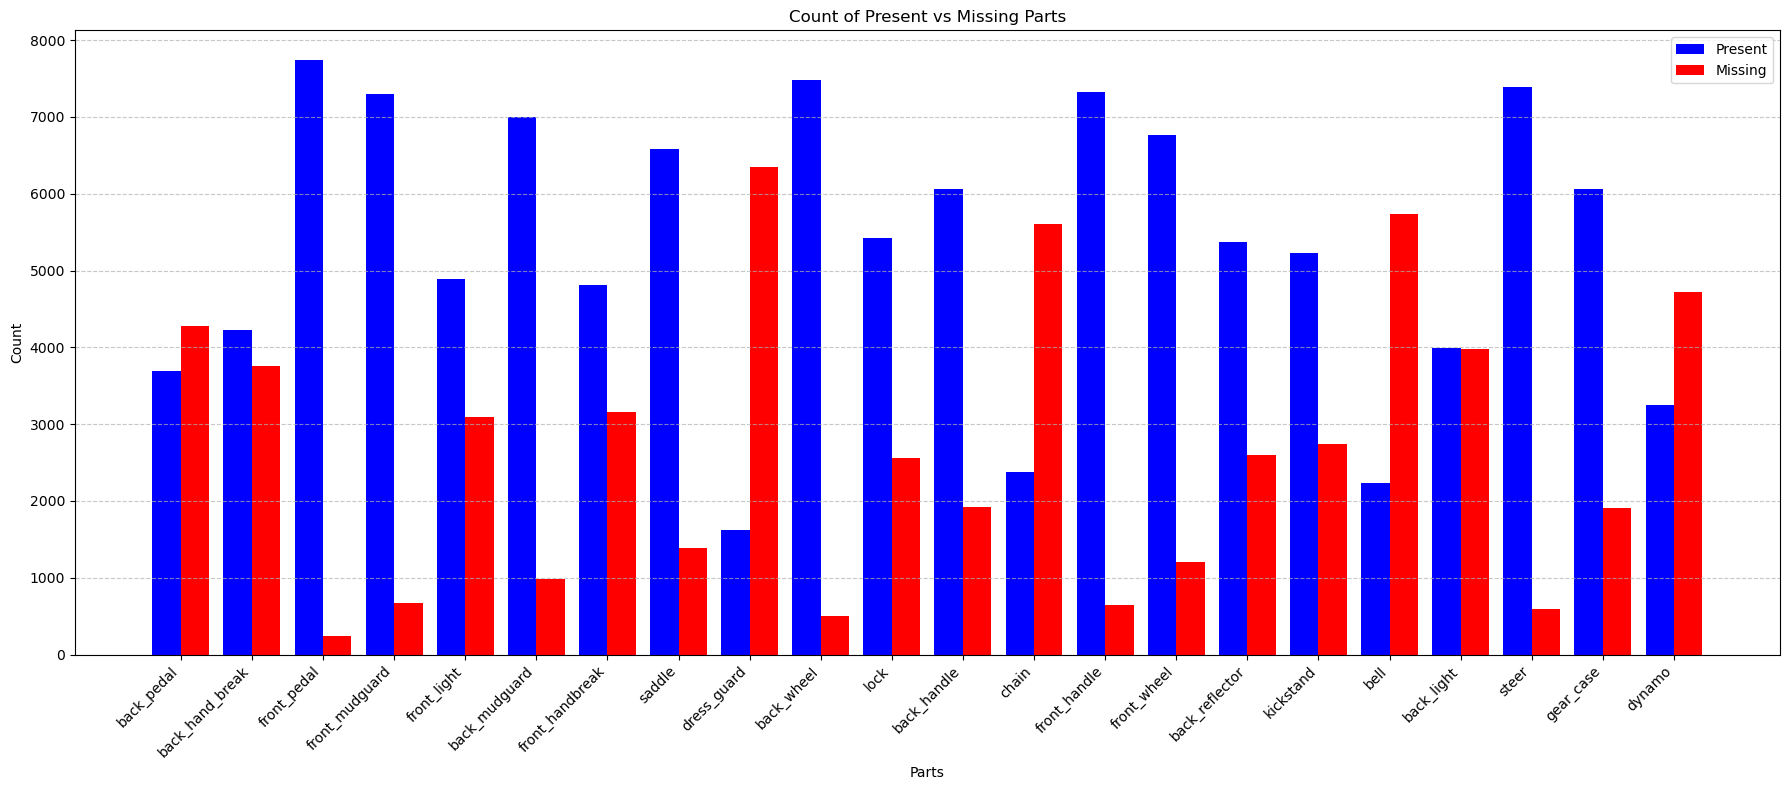

In [12]:
file_path = '../../data/processed/final_annotations_without_occluded.json'
with open(file_path, 'r') as f:
    data = json.load(f)

all_parts = data['all_parts']
images = data['images']

# Initialize count dictionaries
part_counts = {part: {'present': 0, 'missing': 0} for part in all_parts}

# Count present and missing parts
for img_data in images.values():
    available_parts = {part['part_name'] for part in img_data['available_parts']}
    missing_parts = set(img_data['missing_parts'])
    
    for part in all_parts:
        if part in available_parts:
            part_counts[part]['present'] += 1
        elif part in missing_parts:
            part_counts[part]['missing'] += 1

# Prepare data for plotting
parts = list(part_counts.keys())
present_counts = [part_counts[part]['present'] for part in parts]
missing_counts = [part_counts[part]['missing'] for part in parts]

# Plotting
x = range(len(parts))
width = 0.4

plt.figure(figsize=(18, 8))
plt.bar(x, present_counts, width=width, label='Present', color='blue')
plt.bar([i + width for i in x], missing_counts, width=width, label='Missing', color='red')

plt.xlabel('Parts')
plt.ylabel('Count')
plt.title('Count of Present vs Missing Parts')
plt.xticks([i + width / 2 for i in x], parts, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()